In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5]

import numpy as np
import pandas as pd
import seaborn as sns
import statistics as stats
from tqdm import tqdm
import pdb
import copy

import sys
import os

#########################
# Experiment parameters #
#########################
from sklearn.base import clone
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

sys.path.append('../third_party')
sys.path.append('../methods')

## Data generation

In [2]:
from models import GaussianMixture, ConcentricCircles, ConcentricCircles2, ConcentricCirclesMixture, BinomialModel

random_state = 2022

model_name = "BinomialModel"

if model_name == "GaussianMixture":
    p = 20        # Number of features
    a = 0.25         # Signal amplitude
    model = GaussianMixture(p, a, random_state=random_state)
    purity = 0.8    # Proportion of inliers
    n = 1000          # Number of observations
    
elif model_name == "circles":
    p = 1000        # Number of features
    a = 0.7        # Signal amplitude
    model = ConcentricCirclesMixture(p, a, random_state=random_state)
    purity = 0.5      # Proportion of inliers
    n = 1000          # Number of observations

elif model_name == "BinomialModel":
    p = 100        # Number of features
    a = 5          # Signal amplitude
    model = BinomialModel(p, a, random_state=random_state)
    purity = 0.5     # Proportion of inliers
    n = 200          # Number of observations
    
else:
    print("Error: unknown model name!")
    
    
n_test = 100     # Number of test points
purity_test = 0.5 # Proportion of inliers in test set

X, Y = model.sample(n, purity)
X_test, Y_test = model.sample(n_test, purity)

print("Number of inliers in training/calibration data: {}.".format(np.sum(Y==0)))
print("Number of outliers in training/calibration data: {}.".format(np.sum(Y==1)))

print("Number of inliers in test data: {}.".format(np.sum(Y_test==0)))
print("Number of outliers in test data: {}.".format(np.sum(Y_test==1)))

Number of inliers in training/calibration data: 53.
Number of outliers in training/calibration data: 47.
Number of inliers in test data: 60.
Number of outliers in test data: 40.


## Conformal p-values via binary classification

In [3]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

# Define list of possible two-class classifiers with desired hyper-parameters
bbox_bc_list = [RandomForestClassifier(random_state=random_state),
                KNeighborsClassifier(),
                SVC(probability=True),
                GaussianNB(),
                QuadraticDiscriminantAnalysis(),   
                MLPClassifier(max_iter=500, random_state=random_state) 
               ]

# Choose a binary classifier algorithm
bbox_bc = bbox_bc_list[2]

Fitting the black-box model on 26 inliers and 47 outliers... done.
Calculating conformity scores for 27 hold-out inliers... done.
Calculating conformity scores for 100 test points... done.


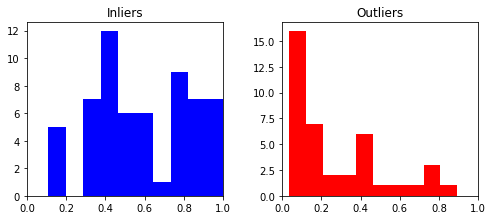

In [4]:
from methods_split import BinaryConformal as BinaryConformal

# Extract the inliers from the data
X_in = X[np.where(Y==0)[0]]
X_out = X[np.where(Y==1)[0]]

# Compute the p-values
method_binary = BinaryConformal(X_in, X_out, bbox_bc, calib_size=0.5, random_state=29)
pvals_binary = method_binary.compute_pvalues(X_test)

## Plot the p-values
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs[0].hist(pvals_binary[Y_test==0], color="blue")
axs[1].hist(pvals_binary[Y_test==1], color="red")  
axs[0].title.set_text('Inliers')
axs[1].title.set_text('Outliers')
axs[0].set_xlim(0,1)
axs[1].set_xlim(0,1)
plt.show()

Fitting the black-box model 0 on 47 inliers and 47 outliers... done.
Fitting the black-box model 1 on 47 inliers and 47 outliers... done.
Fitting the black-box model 2 on 47 inliers and 47 outliers... done.
Fitting the black-box model 3 on 48 inliers and 47 outliers... done.
Fitting the black-box model 4 on 48 inliers and 47 outliers... done.
Fitting the black-box model 5 on 48 inliers and 47 outliers... done.
Fitting the black-box model 6 on 48 inliers and 47 outliers... done.
Fitting the black-box model 7 on 48 inliers and 47 outliers... done.
Fitting the black-box model 8 on 48 inliers and 47 outliers... done.
Fitting the black-box model 9 on 48 inliers and 47 outliers... done.


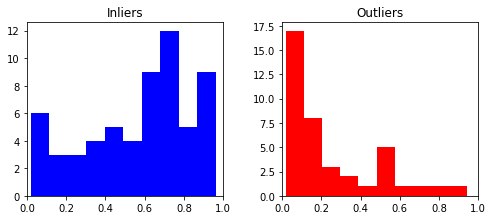

In [5]:
from methods_cv import BinaryConformal as CVBinaryConformal

# Extract the inliers from the data
X_in = X[np.where(Y==0)[0]]
X_out = X[np.where(Y==1)[0]]

# Compute the p-values
method_binary_cv = CVBinaryConformal(X_in, X_out, bbox_bc, n_folds=10, random_state=29)
pvals_binary_cv = method_binary_cv.compute_pvalues(X_test)

## Plot the p-values
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs[0].hist(pvals_binary_cv[Y_test==0], color="blue")
axs[1].hist(pvals_binary_cv[Y_test==1], color="red")  
axs[0].title.set_text('Inliers')
axs[1].title.set_text('Outliers')
axs[0].set_xlim(0,1)
axs[1].set_xlim(0,1)
plt.show()

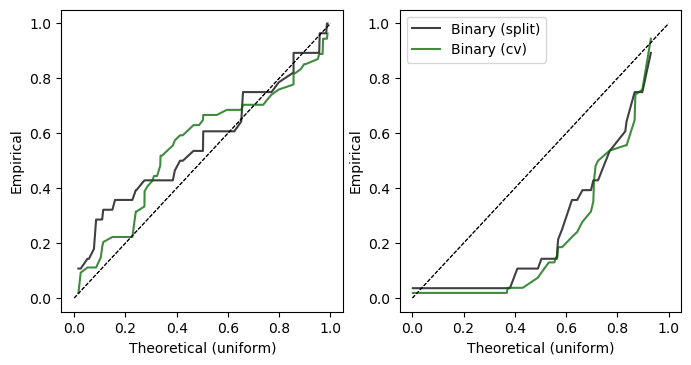

In [6]:
def qq_plot(data, reference, ax, color=None, label=None, logarithm=False):
    sample_size = len(data)
    qq = np.ones([sample_size, 2])
    np.random.shuffle(data)
    qq[:, 0] = np.sort(reference)
    qq[:, 1] = np.sort(data[0:sample_size])
    if color is None:
        ax.plot(qq[:,0], qq[:,1], label=label, alpha=0.75)
    else:
        ax.plot(qq[:,0], qq[:,1], color=color, label=label, alpha=0.75)
    ax.plot([0,1], [0,1], color="black", linewidth=0.75, linestyle="dashed")
    ax.set_xlabel("Theoretical (uniform)")
    ax.set_ylabel("Empirical")
    if logarithm:
        ax.set_xscale('log')
        ax.set_yscale('log')        
        
fig, axs = plt.subplots(1,2, figsize=(8,4), dpi= 100)

logarithm = False
U = np.random.uniform(size = (len(Y_test),))
for y in [0,1]:
    qq_plot(pvals_binary[Y_test==y], U[Y_test==y], axs[y], label="Binary (split)", color='black',
            logarithm=logarithm)
    qq_plot(pvals_binary_cv[Y_test==y], U[Y_test==y], axs[y], label="Binary (cv)", color='darkgreen',
            logarithm=logarithm)
    

plt.legend()
plt.show()

## Conformal p-values via one-class classification

In [7]:
# Define list of possible one-class classifiers with desired hyper-parameters
bbox_occ_list = [svm.OneClassSVM(kernel='rbf'),
                 svm.OneClassSVM(kernel='sigmoid'),
                 svm.OneClassSVM(kernel='poly', degree=3),
                 IsolationForest(contamination = 'auto', random_state=random_state),
                 LocalOutlierFactor(contamination='auto', novelty=True)
               ]

# Choose a one-class classifier algorithm
bbox_occ = bbox_occ_list[1]

Fitting the black-box model on 26 data points... done.
Calculating conformity scores for 27 hold-out data points... done.
Calculating conformity scores for 100 test points... done.


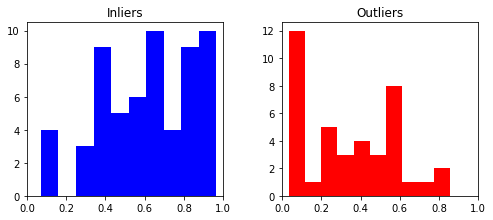

In [8]:
from methods_split import OneClassConformal

# Extract the inliers from the data
X_in = X[Y==0]

# Compute the p-values
method_oneclass = OneClassConformal(X_in, bbox_occ, calib_size=0.5)
pvals_oneclass = method_oneclass.compute_pvalues(X_test)

## Plot the p-values
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs[0].hist(pvals_oneclass[Y_test==0], color="blue")
axs[1].hist(pvals_oneclass[Y_test==1], color="red")  
axs[0].title.set_text('Inliers')
axs[1].title.set_text('Outliers')
axs[0].set_xlim(0,1)
axs[1].set_xlim(0,1)
plt.show()

Fitting the black-box model 0 on 47 inliers... done.
Fitting the black-box model 1 on 47 inliers... done.
Fitting the black-box model 2 on 47 inliers... done.
Fitting the black-box model 3 on 48 inliers... done.
Fitting the black-box model 4 on 48 inliers... done.
Fitting the black-box model 5 on 48 inliers... done.
Fitting the black-box model 6 on 48 inliers... done.
Fitting the black-box model 7 on 48 inliers... done.
Fitting the black-box model 8 on 48 inliers... done.
Fitting the black-box model 9 on 48 inliers... done.


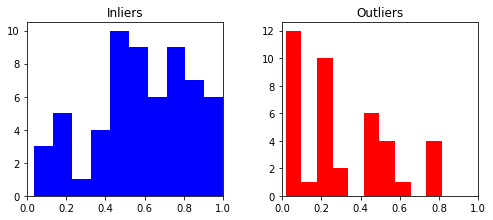

In [9]:
from methods_cv import OneClassConformal as CVOneClassConformal

# Extract the inliers from the data
X_in = X[Y==0]

# Compute the p-values
method_oneclass_cv = CVOneClassConformal(X_in, bbox_occ, n_folds=10)
pvals_oneclass_cv = method_oneclass_cv.compute_pvalues(X_test)

## Plot the p-values
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs[0].hist(pvals_oneclass_cv[Y_test==0], color="blue")
axs[1].hist(pvals_oneclass_cv[Y_test==1], color="red")  
axs[0].title.set_text('Inliers')
axs[1].title.set_text('Outliers')
axs[0].set_xlim(0,1)
axs[1].set_xlim(0,1)
plt.show()

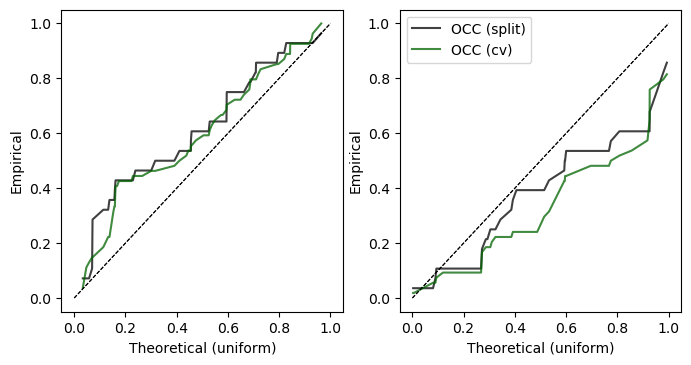

In [10]:
def qq_plot(data, reference, ax, color=None, label=None, logarithm=False):
    sample_size = len(data)
    qq = np.ones([sample_size, 2])
    np.random.shuffle(data)
    qq[:, 0] = np.sort(reference)
    qq[:, 1] = np.sort(data[0:sample_size])
    if color is None:
        ax.plot(qq[:,0], qq[:,1], label=label, alpha=0.75)
    else:
        ax.plot(qq[:,0], qq[:,1], color=color, label=label, alpha=0.75)
    ax.plot([0,1], [0,1], color="black", linewidth=0.75, linestyle="dashed")
    ax.set_xlabel("Theoretical (uniform)")
    ax.set_ylabel("Empirical")
    if logarithm:
        ax.set_xscale('log')
        ax.set_yscale('log')        
        
fig, axs = plt.subplots(1,2, figsize=(8,4), dpi= 100)

logarithm = False
U = np.random.uniform(size = (len(Y_test),))
for y in [0,1]:
    qq_plot(pvals_oneclass[Y_test==y], U[Y_test==y], axs[y], label="OCC (split)", color='black',
            logarithm=logarithm)
    qq_plot(pvals_oneclass_cv[Y_test==y], U[Y_test==y], axs[y], label="OCC (cv)", color='darkgreen',
            logarithm=logarithm)
    

plt.legend()
plt.show()

## Integrative conformal p-values

Fitting a one-class classification model on 26 data points... done.
Fitting a one-class classification model on 26 data points... done.
Fitting a one-class classification model on 26 data points... done.
Fitting a one-class classification model on 26 data points... done.
Fitting a one-class classification model on 26 data points... done.
Fitting a one-class classification model on 23 data points... done.
Fitting a one-class classification model on 23 data points... done.
Fitting a one-class classification model on 23 data points... done.
Fitting a one-class classification model on 23 data points... done.
Fitting a one-class classification model on 23 data points... done.


100%|██████████| 100/100 [00:00<00:00, 420.35it/s]


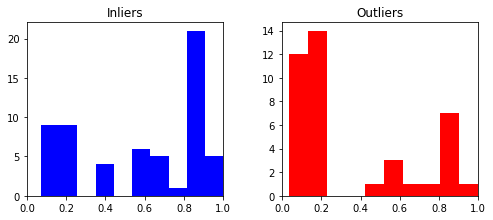

In [11]:
from methods_split import IntegrativeConformal

# Extract the inliers from the data
X_in = X[Y==0]
X_out = X[Y==1]

# Choose a family of one-class classifiers
bboxes_one = bbox_occ_list

# Compute the p-values
method_int = IntegrativeConformal(X_in, X_out, bboxes_one=bboxes_one, calib_size=0.5, tuning=True)
pvals_int = method_int.compute_pvalues(X_test, return_prepvals=False)

## Plot the p-values
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs[0].hist(pvals_int[Y_test==0], color="blue")
axs[1].hist(pvals_int[Y_test==1], color="red")  
axs[0].title.set_text('Inliers')
axs[1].title.set_text('Outliers')
axs[0].set_xlim(0,1)
axs[1].set_xlim(0,1)
plt.show()

In [12]:
Y_test[0]

0

Fitting the black-box model 0 on fold 0, which contains 23 outliers... done.
Fitting the black-box model 0 on fold 1, which contains 24 outliers... done.
Fitting the black-box model 1 on fold 0, which contains 23 outliers... done.
Fitting the black-box model 1 on fold 1, which contains 24 outliers... done.
Fitting the black-box model 2 on fold 0, which contains 23 outliers... done.
Fitting the black-box model 2 on fold 1, which contains 24 outliers... done.
Fitting the black-box model 3 on fold 0, which contains 23 outliers... done.
Fitting the black-box model 3 on fold 1, which contains 24 outliers... done.


100%|██████████| 100/100 [00:31<00:00,  3.22it/s]


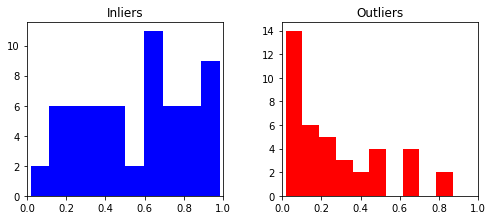

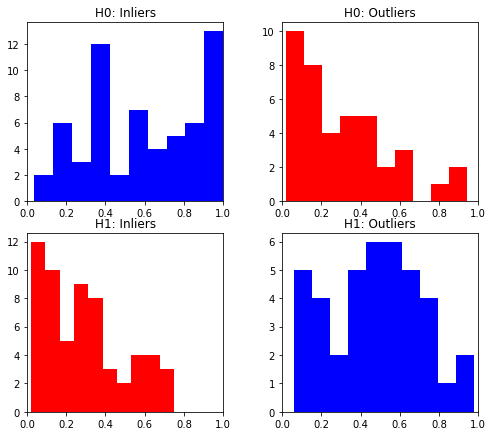

In [14]:
from methods_cv import IntegrativeConformal as CVIntegrativeConformal

# Extract the inliers from the data
X_in = X[Y==0]
X_out = X[Y==1]

# Choose a family of one-class classifiers
bboxes_one = bbox_occ_list

# Compute the p-values
method_int_cv = CVIntegrativeConformal(X_in, X_out, bboxes_one=bboxes_one[:-1], n_folds=2, ratio=True, tuning=True)
pvals_int_cv, pvals_int_cv_0, pvals_int_cv_1 = method_int_cv.compute_pvalues(X_test, return_prepvals=True)

## Plot the p-values
fig, axs = plt.subplots(1,2, figsize=(7,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs[0].hist(pvals_int_cv[Y_test==0], color="blue")
axs[1].hist(pvals_int_cv[Y_test==1], color="red")  
axs[0].title.set_text('Inliers')
axs[1].title.set_text('Outliers')
axs[0].set_xlim(0,1)
axs[1].set_xlim(0,1)
plt.show()

## Plot the preliminary p-values
fig, axs = plt.subplots(2,2, figsize=(7,6))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
axs[0,0].hist(pvals_int_cv_0[Y_test==0], color="blue")
axs[0,1].hist(pvals_int_cv_0[Y_test==1], color="red")  
axs[1,0].hist(pvals_int_cv_1[Y_test==0], color="red")
axs[1,1].hist(pvals_int_cv_1[Y_test==1], color="blue")  
axs[0,0].title.set_text('H0: Inliers')
axs[0,1].title.set_text('H0: Outliers')
axs[1,0].title.set_text('H1: Inliers')
axs[1,1].title.set_text('H1: Outliers')
axs[0,0].set_xlim(0,1)
axs[0,1].set_xlim(0,1)
axs[1,0].set_xlim(0,1)
axs[1,1].set_xlim(0,1)
plt.show()

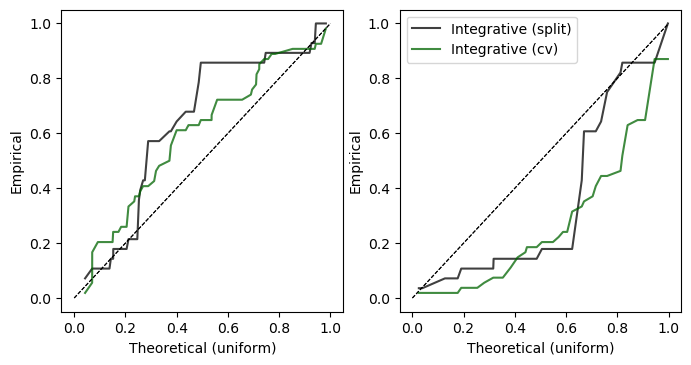

In [15]:
def qq_plot(data, reference, ax, color=None, label=None, logarithm=False):
    sample_size = len(data)
    qq = np.ones([sample_size, 2])
    np.random.shuffle(data)
    qq[:, 0] = np.sort(reference)
    qq[:, 1] = np.sort(data[0:sample_size])
    if color is None:
        ax.plot(qq[:,0], qq[:,1], label=label, alpha=0.75)
    else:
        ax.plot(qq[:,0], qq[:,1], color=color, label=label, alpha=0.75)
    ax.plot([0,1], [0,1], color="black", linewidth=0.75, linestyle="dashed")
    ax.set_xlabel("Theoretical (uniform)")
    ax.set_ylabel("Empirical")
    if logarithm:
        ax.set_xscale('log')
        ax.set_yscale('log')        
        
fig, axs = plt.subplots(1,2, figsize=(8,4), dpi= 100)

logarithm = False
U = np.random.uniform(size = (len(Y_test),))
for y in [0,1]:
    qq_plot(pvals_int[Y_test==y], U[Y_test==y], axs[y], label="Integrative (split)", color='black',
            logarithm=logarithm)
    qq_plot(pvals_int_cv[Y_test==y], U[Y_test==y], axs[y], label="Integrative (cv)", color='darkgreen',
            logarithm=logarithm)
    

plt.legend()
plt.show()